In [1]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
# import ppscore as pps # ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but you have scikit-learn 1.1.2 which is incompatible.

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.graphics.gofplots import qqplot
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_selector as selector
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, mean_squared_log_error
import sklearn.metrics as metrics


from housing_crawler.analysis.ads_table_processing import get_processed_ads_table
from housing_crawler.utils import return_significative_coef

%load_ext autoreload
%autoreload 2

# Prepare data

## Obtain data for WGs

In [2]:
df_original = get_processed_ads_table()


/home/carlo/code/chvieira2/housing_crawler/housing_crawler/utils.py:35: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(local_path)


===> Loaded ads_OSM.csv locally


In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26193 entries, 0 to 26192
Columns: 143 entries, id to cos_day_week_int
dtypes: float64(117), int64(5), object(21)
memory usage: 28.6+ MB


In [4]:
ads_feat_df = df_original[df_original['details_searched']==1]
# ads_feat_df = ads_feat_df[ads_feat_df['city'].isin(['Berlin'])]#, 'München', 'Hamburg', 'Stuttgart', 'Köln', 'Münster', 'Leipzig', 'Frankfurt am Main'])]
ads_feat_df = ads_feat_df.set_index('id')

## Remove duplicates if exist

In [5]:
# Number of duplicate data points
# It's very likely zero cause I already removed dulicated IDs during processing
ads_feat_df.duplicated().sum()

0

## Filter data accordingly

In [6]:
# Filter only ads that have been searched for details (search added from august on)
df_filtered = ads_feat_df.copy()
df_filtered = df_filtered[df_filtered['type_offer_simple']=='WG']
df_filtered = df_filtered[df_filtered['km_to_centroid'].notna()]
df_filtered.describe()

,commercial_landlord,price_euros,size_sqm,available_rooms,capacity,available_spots_wg,male_flatmates,female_flatmates,diverse_flatmates,published_at,latitude,longitude,details_searched,cold_rent_euros,mandatory_costs_euros,extra_costs_euros,transfer_costs_euros,deposit,zip_code,home_total_size,wg_possible,building_floor,public_transport_distance,schufa_needed,min_age_flatmates,max_age_flatmates,min_age_searched,max_age_searched,construction_year,energy_usage,energy_efficiency_class,number_languages,internet_speed,toilet,internet_dsl,internet_wlan,internet_flatrate,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,tv_kabel,tv_satellit,price_per_sqm,days_available,furniture_numerical,kitchen_numerical,smoking_numerical,km_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,activities_public_service,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,comfort_green_forests,mobility_street_primary,comfort_lakes,activities_health_regional,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway,sin_degrees_to_centroid,cos_degrees_to_centroid,sin_published_at,cos_published_at,sin_day_week_int,cos_day_week_int
count,7828.000000,7828.000000,7828.000000,7828.0,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,6151.000000,7828.000000,7828.000000,7828.0,7828.000000,6173.000000,4904.000000,3610.000000,6810.000000,7814.000000,5386.000000,7828.0,6973.000000,6897.000000,7828.000000,5944.00000,5522.000000,7828.000000,7828.000000,880.000000,279.000000,406.000000,7828.000000,2380.000000,17.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.00000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7.828000e+03,7828.000000,7828.000000,7828.000000,7.828000e+03,7828.0,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.0,7828.000000,7828.000000,7828.0,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,6.151000e+03,6151.000000,7828.000000,7828.000000
mean,0.007665,482.396909,17.363056,1.0,3.271972,1.269034,0.952606,1.033214,0.017118,14.955942,50.922244,10.222425,1.0,388.503066,74.134942,10.769576,62.958172,652.856094,44832.315587,91.640921,1.0,2.003298,3.209221,0.086101,24.20895,30.413256,13.562468,59.032448,1945.087500,277.716846,6.029557,2.096449,5.842857,0.794118,0.372126,0.712443,0.2097

## Drop columns I won't use for modelling

In [7]:
# Drop unnecessary columns
df_filtered = df_filtered[[
#         'url',
        'commercial_landlord',
#         'title',
#         'type_offer_simple',
        'size_sqm',
#         'home_total_size',
#         'available_rooms',
        'capacity',
#         'available_spots_wg',
    
#         'address',
        'city',
#         'zip_code',
#         'latitude',
#         'longitude',
    
#         'published_on',
#         'published_at',
#         'day_of_week_publication',
#         'available_from',
#         'available_to',
        'days_available',
        'rental_length_term',
#         'sin_published_at',
#         'cos_published_at',
#         'sin_day_week_int',
#         'cos_day_week_int',
    
#         'details_searched',
#         'crawler',
    
# Values
#         'price_euros',    
        'cold_rent_euros',
#         'mandatory_costs_euros',
#         'extra_costs_euros',
#         'deposit',
        'transfer_costs_euros',
#         'price_per_sqm',

# Flatmates
        'male_flatmates',
        'female_flatmates',
        'diverse_flatmates',
        'min_age_flatmates',
        'max_age_flatmates',
    
# Person searched
        'gender_searched',
        'min_age_searched',
        'max_age_searched',
        'age_category_searched',
    
# Details
    
        'schufa_needed',
#         'wg_possible',
    
#         'smoking',
        'smoking_numerical',
        'building_type',
        'building_floor',
#         'furniture',
        'furniture_numerical',
#         'kitchen',
        'kitchen_numerical',
        'heating',
        'public_transport_distance',
        'parking',
    
#         'construction_year',
#         'energy_certificate',
#         'energy_usage',
#         'energy_efficiency_class',
#         'heating_energy_source',
    
        'tv_kabel',
        'tv_satellit',
    
#         'toilet',
        'shower_type_badewanne',
        'shower_type_dusche',
    
        'floor_type_dielen',
        'floor_type_parkett',
        'floor_type_laminat',
        'floor_type_teppich',
        'floor_type_fliesen',
        'floor_type_pvc',
        'floor_type_fußbodenheizung',
    
        'extras_waschmaschine',
        'extras_spuelmaschine',
        'extras_terrasse',
        'extras_balkon',
        'extras_garten',
        'extras_gartenmitbenutzung',
        'extras_keller',
        'extras_aufzug',
        'extras_haustiere',
        'extras_fahrradkeller',
        'extras_dachboden',
    
# WG only
        'number_languages',
        'languages_deutsch',
        'languages_englisch',
    
        'wg_type_studenten',
        'wg_type_keine_zweck',
        'wg_type_maenner',
        'wg_type_business',
        'wg_type_wohnheim',
        'wg_type_vegetarisch_vegan',
        'wg_type_alleinerziehende',
        'wg_type_funktionale',
        'wg_type_berufstaetigen',
        'wg_type_gemischte',
        'wg_type_mit_kindern',
        'wg_type_verbindung',
        'wg_type_lgbtqia',
        'wg_type_senioren',
        'wg_type_inklusive',
        'wg_type_wg_neugruendung',
    
        'internet_speed',
        'internet_dsl',
        'internet_wlan',
        'internet_flatrate',
    

# Geographical
        'km_to_centroid',
        'sin_degrees_to_centroid',
        'cos_degrees_to_centroid',

# OSM features
        'comfort_leisure_spots',
        'comfort_warehouse',
        'activities_education',
        'mobility_public_transport_bus',
        'activities_economic',
        'comfort_industrial',
        'activities_goverment',
        'social_life_eating',
        'comfort_comfort_spots',
        'social_life_culture',
        'activities_supermarket',
#         'activities_public_service',
        'social_life_community',
        'comfort_leisure_mass',
        'activities_educational',
        'mobility_street_secondary',
        'mobility_public_transport_rail',
        'activities_retail',
        'social_life_night_life',
        'comfort_green_natural',
        'comfort_railway',
        'mobility_bike_infraestructure',
#         'comfort_green_forests',
        'mobility_street_primary',
        'comfort_lakes',
#         'activities_health_regional',
        'activities_health_local',
        'comfort_green_space',
        'comfort_rivers',
        'activities_post',
        'comfort_green_parks',
        'comfort_street_motorway'
        ]]

## Define numerical and categorical columns

In [8]:
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df_filtered)
categorical_columns = categorical_columns_selector(df_filtered)
# categorical_columns.remove('city')

## Scorer to maximaze

In [ ]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import make_scorer

# This is our metric to minimize
rmsle = make_scorer(lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5)

# This is our score to maximize
rmsle_neg = make_scorer(lambda y_true, y_pred: -1 * mean_squared_log_error(y_true, y_pred)**0.5)

# Equivalent formulation
rmsle_neg = make_scorer(
    lambda y_true, y_pred: mean_squared_log_error(y_true, y_pred)**0.5,
    greater_is_better=False
)

# Removing outliers

In [9]:
### List of columns with manually inserted values that would possibly contain outliers and/werid values

manually_inserted_values_columns = [
#     'price_euros',
    'size_sqm',
    'cold_rent_euros',
#     'mandatory_costs_euros',
#     'extra_costs_euros',
#     'deposit',
#     'home_total_size',
    'public_transport_distance',
    'transfer_costs_euros',
    'min_age_flatmates',
    'max_age_flatmates',
    'min_age_searched',
    'max_age_searched',
#     'construction_year',
#     'energy_usage'
]

'max_age_flatmates'

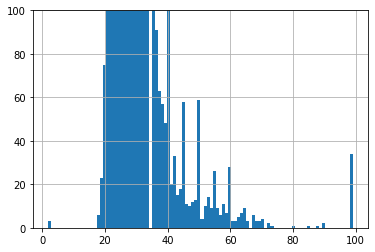

In [10]:
### Manually look into the variable distribution to identify outliers
col = manually_inserted_values_columns[5]
df_filtered[col].hist(bins = 100);
# df_filtered[[col]].boxplot()
# plt.xlim(0,1000)
plt.ylim(0,100);
col

In [11]:
#### Manage identified outliers
# max_age_flatmates
# There are some ads with really extreme energy usage values (<18 or >80). These were removed for modelling
df_filtered['max_age_flatmates'] = [np.nan if (value!=value) or value < 18 or value >80 else value for value in list(df_filtered['max_age_flatmates'])]

# public_transport_distance
# Remove values of public transport above 30 min
df_filtered['public_transport_distance'] = [np.nan if (value!=value) or value > 30 else value for value in list(df_filtered['public_transport_distance'])]

# min_age_flatmates
# Create a new variable flat_with_kids if the minimum age of flatmates is below 18
df_filtered['flat_with_kids'] = [1.0 if value < 18 else 0.0 for value in list(df_filtered['min_age_flatmates'])]
# Limit minimal age of flat mates to 18 and 80 yo
df_filtered['min_age_flatmates'] = [np.nan if (value!=value) or value < 18 or value >80 else value for value in list(df_filtered['min_age_flatmates'])]

# cold_rent_euros
# Remove ridiculously small cold_rent_euros values
# df_filtered['cold_rent_euros'] = [np.nan if (value!=value) or value < 100 else value for value in list(df_filtered['cold_rent_euros'])]

# price_per_sqm
## Remove offeers with absurd values for price/sqm above 100
# df_filtered['price_per_sqm'] = [np.nan if (value!=value) or value > 100 else value for value in list(df_filtered['price_per_sqm'])]
# df_filtered = df_filtered[df_filtered['price_per_sqm'].notna()]

In [12]:
df_filtered.describe()

,commercial_landlord,size_sqm,capacity,days_available,cold_rent_euros,transfer_costs_euros,male_flatmates,female_flatmates,diverse_flatmates,min_age_flatmates,max_age_flatmates,min_age_searched,max_age_searched,schufa_needed,smoking_numerical,building_floor,furniture_numerical,kitchen_numerical,public_transport_distance,tv_kabel,tv_satellit,shower_type_badewanne,shower_type_dusche,floor_type_dielen,floor_type_parkett,floor_type_laminat,floor_type_teppich,floor_type_fliesen,floor_type_pvc,floor_type_fußbodenheizung,extras_waschmaschine,extras_spuelmaschine,extras_terrasse,extras_balkon,extras_garten,extras_gartenmitbenutzung,extras_keller,extras_aufzug,extras_haustiere,extras_fahrradkeller,extras_dachboden,number_languages,languages_deutsch,languages_englisch,wg_type_studenten,wg_type_keine_zweck,wg_type_maenner,wg_type_business,wg_type_wohnheim,wg_type_vegetarisch_vegan,wg_type_alleinerziehende,wg_type_funktionale,wg_type_berufstaetigen,wg_type_gemischte,wg_type_mit_kindern,wg_type_verbindung,wg_type_lgbtqia,wg_type_senioren,wg_type_inklusive,wg_type_wg_neugruendung,internet_speed,internet_dsl,internet_wlan,internet_flatrate,km_to_centroid,sin_degrees_to_centroid,cos_degrees_to_centroid,comfort_leisure_spots,comfort_warehouse,activities_education,mobility_public_transport_bus,activities_economic,comfort_industrial,activities_goverment,social_life_eating,comfort_comfort_spots,social_life_culture,activities_supermarket,social_life_community,comfort_leisure_mass,activities_educational,mobility_street_secondary,mobility_public_transport_rail,activities_retail,social_life_night_life,comfort_green_natural,comfort_railway,mobility_bike_infraestructure,mobility_street_primary,comfort_lakes,activities_health_local,comfort_green_space,comfort_rivers,activities_post,comfort_green_parks,comfort_street_motorway,flat_with_kids
count,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,3610.000000,7828.000000,7828.000000,7828.000000,5856.000000,5481.000000,7828.000000,7828.000000,7828.000000,7828.000000,6973.000000,7828.000000,7828.000000,6896.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.00000,7828.000000,7828.000000,2380.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7.828000e+03,7828.000000,7828.000000,7828.000000,7.828000e+03,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000,7828.000000
mean,0.007665,17.363056,3.271972,485.835718,388.503066,62.958172,0.952606,1.033214,0.017118,24.414959,29.961138,13.562468,59.032448,0.086101,0.196634,2.003298,0.533789,0.003545,3.200986,0.176162,0.049182,0.262519,0.309402,0.150613,0.215892,0.283725,0.055697,0.193281,0.069494,0.033470,0.739653,0.545350,0.106668,0.423863,0.259070,0.183444,0.462570,0.111267,0.071538,0.318983,0.000128,2.096449,0.842233,0.722407,0.480583,0.404701,0.010731,0.023761,0.005749,0.047905,0.003960,0.012775,0.356668,0.384389,0.007537,0.005238,0.103602,0.00115,0.008304,0.025677,5.842857,0.372126,0.712443,0.209760,3.624826,0.026706,-0.106286,0.074629,0.109620,0.017110,0.274672,0.154579,0.866674,1.053245e-03,0.819931,1.122878,0.032600,1.138810e-02,0.052886,0.017543,0.091223,2.478225,0.210414,1.812294,0.250408,0.303754,0.703362,1.137583,1.297044,0.993325,0.224808,1.418911,0.061874,0.163028,2.010469,0.022135,0.011114
std,0.087218,5.628940,1.609270,323.573420,150.086791,181.825525,1.012848,1.143659,0.2465

# Dealing with NAs

In [13]:
df_imputted = df_filtered.copy()

In [14]:
# Percentage missing values per column before imputting
(df_imputted.isnull().sum().sort_values(ascending=False)/len(df_imputted)*100)[0:10]

internet_speed               69.596321
heating                      57.064384
transfer_costs_euros         53.883495
parking                      41.939193
max_age_flatmates            29.982115
min_age_flatmates            25.191620
building_type                20.848237
public_transport_distance    11.905979
building_floor               10.922330
comfort_leisure_spots         0.000000
dtype: float64

## Imputting numerical columns

'internet_speed'

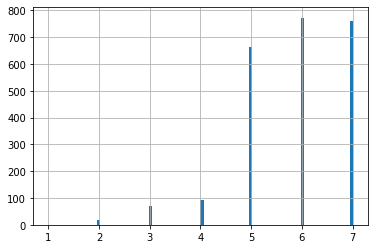

In [15]:
num_cols_imputing = ['internet_speed',
                     'max_age_flatmates','min_age_flatmates',
#                     'cos_published_at', 'sin_published_at',
                    'public_transport_distance','building_floor']

col = num_cols_imputing[0]
df_imputted[col].hist(bins = 100);
# df_filtered[[col]].boxplot()
# plt.xlim(0,300)
# plt.ylim(0,100);
col

In [16]:
num_cols_imputing_mean = ['min_age_flatmates', 'max_age_flatmates']
num_cols_imputing_median = ['internet_speed', 'public_transport_distance', 'building_floor'] 

num_imputer_mean = SimpleImputer(strategy="mean") # Instantiate a SimpleImputer object with your strategy of choice
num_imputer_median = SimpleImputer(strategy="median") # Instantiate a SimpleImputer object with your strategy of choice

num_imputer_mean.fit(df_imputted[num_cols_imputing_mean]) # Call the "fit" method on the object
num_imputer_median.fit(df_imputted[num_cols_imputing_median]) # Call the "fit" method on the object

df_imputted[num_cols_imputing_mean] = num_imputer_mean.transform(df_imputted[num_cols_imputing_mean]) # Call the "transform" method on the object
df_imputted[num_cols_imputing_median] = num_imputer_median.transform(df_imputted[num_cols_imputing_median]) # Call the "transform" method on the object

num_imputer_mean.statistics_,  num_imputer_median.statistics_# The mean is stored in the transformer's memory

(array([24.41495902, 29.96113848]), array([6., 3., 2.]))

In [17]:
# Percentage missing values per column after imputing
(df_imputted.isnull().sum().sort_values(ascending=False)/len(df_imputted)*100)[0:10]

heating                          57.064384
transfer_costs_euros             53.883495
parking                          41.939193
building_type                    20.848237
commercial_landlord               0.000000
internet_dsl                      0.000000
mobility_public_transport_bus     0.000000
activities_education              0.000000
comfort_warehouse                 0.000000
comfort_leisure_spots             0.000000
dtype: float64

## Imputting categorical columns

In [18]:
# For some unknown reason imputting for transfer_costs_euros doesn't work, so I manually imput 0 values here for transfer_costs_euros without a answer
features_noanswer = ['transfer_costs_euros']

noanswer_imputer = SimpleImputer(strategy="constant", fill_value=0) 

noanswer_imputer.fit(df_imputted[features_noanswer])

df_imputted[features_noanswer] = noanswer_imputer.transform(df_imputted[features_noanswer])

In [19]:
# Features in which NaN values represent something
features_noanswer = ['heating', 'parking', 'building_type']

noanswer_imputer = SimpleImputer(strategy="constant", fill_value="no_answer") 

noanswer_imputer.fit(df_imputted[features_noanswer])

df_imputted[features_noanswer] = noanswer_imputer.transform(df_imputted[features_noanswer])

In [20]:
# Percentage missing values per column after imputing
(df_imputted.isnull().sum().sort_values(ascending=False)/len(df_imputted)*100)[0:10]

commercial_landlord        0.0
size_sqm                   0.0
activities_education       0.0
comfort_warehouse          0.0
comfort_leisure_spots      0.0
cos_degrees_to_centroid    0.0
sin_degrees_to_centroid    0.0
km_to_centroid             0.0
internet_flatrate          0.0
internet_wlan              0.0
dtype: float64

# Scaling columns

In [21]:
df_scaled = df_imputted.copy()

## Find colums for each type of scaling

In [22]:
features_OSM = [
                'comfort_leisure_spots',
                'comfort_warehouse',
                'activities_education',
                'mobility_public_transport_bus',
                'activities_economic',
                'comfort_industrial',
                'activities_goverment',
                'social_life_eating',
                'comfort_comfort_spots',
                'social_life_culture',
                'activities_supermarket',
#                 'activities_public_service',
                'social_life_community',
                'comfort_leisure_mass',
                'activities_educational',
                'mobility_street_secondary',
                'mobility_public_transport_rail',
                'activities_retail',
                'social_life_night_life',
                'comfort_green_natural',
                'comfort_railway',
                'mobility_bike_infraestructure',
#                 'comfort_green_forests',
                'mobility_street_primary',
                'comfort_lakes',
#                 'activities_health_regional',
                'activities_health_local',
                'comfort_green_space',
                'comfort_rivers',
                'activities_post',
                'comfort_green_parks',
                'comfort_street_motorway']

In [23]:
continuous_num_cols = ['size_sqm', 'public_transport_distance', 'km_to_centroid'] + features_OSM

In [24]:
# for numerical_feature in continuous_num_cols:
#     fig, ax = plt.subplots(1,3, figsize = (15,5))
    
#     ax[0].set_title(f"Distribution of {numerical_feature}")
#     sns.histplot(x = df_scaled[numerical_feature], kde = True, ax = ax[0])
    
#     ax[1].set_title(f"Boxplot of {numerical_feature}")
#     sns.boxplot(x = df_scaled[numerical_feature], ax = ax[1])
    
#     ax[2].set_title(f"QQplot of {numerical_feature}")
#     qqplot(df_scaled[numerical_feature], line='s', ax = ax[2])

['size_sqm', 'public_transport_distance', 'km_to_centroid']


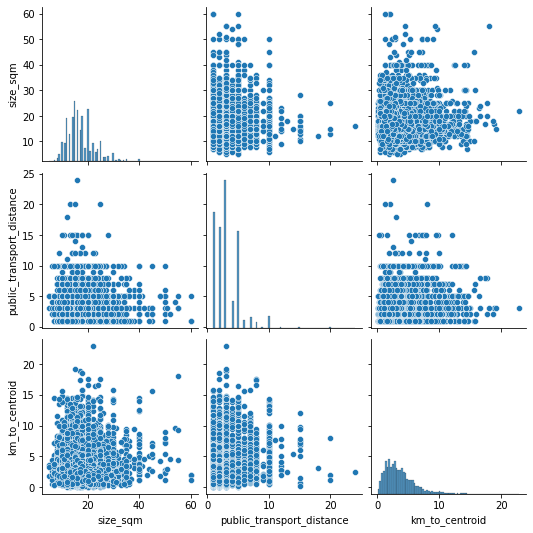

In [25]:
cols = continuous_num_cols[0:3]#numerical_columns[0:3]
sns.pairplot(df_scaled.reset_index(), vars=cols);
print(cols)

In [26]:
cols_minmax_scaler = ['capacity', 'transfer_costs_euros', 
                      'male_flatmates', 'female_flatmates', 'diverse_flatmates',
                      'min_age_flatmates', 'max_age_flatmates', 'min_age_searched', 'max_age_searched',
                      'smoking_numerical', 'building_floor', 'furniture_numerical', 'kitchen_numerical',
                      'number_languages', 'internet_speed', 'sin_degrees_to_centroid', 'cos_degrees_to_centroid'] + features_OSM
cols_standard_scaler = ['size_sqm', 'km_to_centroid']
cols_robust_scaler = ['public_transport_distance']

## Scaling features

In [ ]:
# Instanciate MinMaxScaler
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

# Fit scaler to data
minmax_scaler.fit(df_scaled[cols_minmax_scaler])
standard_scaler.fit(df_scaled[cols_standard_scaler])
robust_scaler.fit(df_scaled[cols_robust_scaler])

# Use scaler to transform data
df_scaled[cols_minmax_scaler] = minmax_scaler.transform(df_scaled[cols_minmax_scaler])
df_scaled[cols_standard_scaler] = standard_scaler.transform(df_scaled[cols_standard_scaler])
df_scaled[cols_robust_scaler] = robust_scaler.transform(df_scaled[cols_robust_scaler])

In [ ]:
df_scaled.describe()

# OneHot encoding

In [ ]:
ohe = OneHotEncoder(sparse=False, drop='if_binary', categories='auto')
feature_arr = ohe.fit_transform(df_filtered[categorical_columns])

## Get name of new columns and create new dataframe
feature_labels = ohe.get_feature_names_out()
feature_labels = np.array(feature_labels).ravel()
features = pd.DataFrame(feature_arr, columns=feature_labels)

In [ ]:
# Give correct indexes to feature table. Needed for concatenating
features.index = df_filtered.index
## Add new columns to dataframe
df_processed = pd.concat([df_scaled, features], axis = 1).drop(columns=categorical_columns)
df_processed.columns = [col.lower().replace(' ', '_').replace('ä','ae').replace('ö','oe').replace('ü','ue').replace('ß','ss') for col in df_processed.columns]

In [ ]:
df_processed.shape

# Minimize features

In [ ]:
df_minimal = df_processed.copy()

In [ ]:
df_minimal.shape

In [ ]:
# Define columns to be tested. Don't test the target, commercial_landlord and 'city'
cols_to_search = [col for col in df_minimal.columns if col not in ['cold_rent_euros', 'commercial_landlord']]
cols_to_search = [col for col in cols_to_search if not col.startswith('city_')]

cols_exclude = []
for col in cols_to_search:
    # How many times the most frequent val exists
    most_freq_count = list(df_minimal[col].value_counts())[0]
    
    if most_freq_count > len(df_minimal)*0.99:
        cols_exclude.append(col)

        
# Exclude all columns (except cities) with >99% of the same value (0) as it contains very little information
df_minimal = df_minimal.drop(columns=cols_exclude)
df_minimal.shape

In [ ]:
cols_exclude

# Colinearity

In [ ]:
df_analysed = df_minimal.copy()

In [ ]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))

data_corr = df_minimal.corr()
sns.heatmap(data_corr, cmap='coolwarm', 
            annot = False, 
            annot_kws={"size": 8},
            vmin=-1, vmax=1);

In [ ]:
df_analysed = df_analysed.drop(columns=['age_category_searched_20_100',
                                        'rental_length_term_plus540days',
                                        #'extras_gartenmitbenutzung',
                                        'gender_searched_egal'
                                       ])

In [ ]:
data_corr = df_analysed.corr()

corr_df = data_corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
# corr_df['correlation'] = -corr_df['correlation'] # Invert signal to see negative correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.head(30)

In [ ]:
# These are columns that are always removed, so I'm removing them prematurely to reduce the calculation time
# df_analysed = df_analysed.drop(columns = ['internet_speed',
#                     'max_age_searched',
# #                     'rental_length_term_plus540days',
#                     'days_available',
#                     'min_age_flatmates',
#                     'min_age_searched'
#                   ])

In [ ]:
# Automatized Variation Inflation Factor (VIF) analysis
# Removing columns must be done one at a time because they influence each others VIF results

remove = True
cols_to_exclude = []
while remove:
    df = pd.DataFrame()
    
    selected_columns = ['cold_rent_euros'] # Ignore the targer column
    selected_columns = [col for col in df_analysed.columns.to_list() if col not in selected_columns]

    df["features"] = selected_columns

    df["vif_index"] = [vif(df_analysed[selected_columns].values, i) for i in range(df_analysed[selected_columns].shape[1])]

    df = round(df.sort_values(by="vif_index", ascending = False),2)
    
    df = df.head(1)

    if float(df.vif_index) >= 10:
        print(df)
        cols_to_exclude = cols_to_exclude + df.features.to_list()
        df_analysed = df_analysed.drop(columns = df.features)
    else:
        remove = False

cols_to_exclude

In [ ]:
# Variation Inflation Factor (VIF) analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df = pd.DataFrame()


selected_columns = [col for col in df_analysed.columns.to_list() if col not in ['cold_rent_euros']]

df["features"] = selected_columns

df["vif_index"] = [vif(df_analysed[selected_columns].values, i) for i in range(df_analysed[selected_columns].shape[1])]

round(df.sort_values(by="vif_index", ascending = False),2)[:10]

In [ ]:
df_analysed.info()

# Feature permutation

In [ ]:
df_permuted = df_analysed.copy()

## Permutation analysis

In [ ]:
X = df_permuted.drop(columns=['cold_rent_euros'])
y = df_permuted['cold_rent_euros']

model = Ridge().fit(X, y) # Fit model

In [ ]:
permutation_score = permutation_importance(model, X, y,
                                           scoring = ['r2','neg_root_mean_squared_error'],
                                           n_repeats=100, n_jobs=-1) # Perform Permutation

In [ ]:
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        permutation_score['r2'].importances_mean,
                                       permutation_score['r2'].importances_std,
                                        permutation_score['neg_root_mean_squared_error'].importances_mean,
                                       permutation_score['neg_root_mean_squared_error'].importances_std)).T) # Unstack results

importance_df.columns=['feature',
                       'r2 feature importance','r2 feature importance std',
                       'RMSE feature importance','RMSE feature importance std']

In [ ]:
importance_df = importance_df.sort_values(by="r2 feature importance", ascending = False) # Order by importance
importance_df[:50]

In [ ]:
top_features = []
scores = []

for features in range(1, len(importance_df)): # Loop over the total number of features
    
    most_important_features = list(importance_df.head(features).feature) # List the name of the features in specific loop
   
    X_reduced = X[most_important_features] # Make feature set with the selected features
    
    cv_results = cross_val_score(model, X_reduced, y, cv=10) # cross validate
    
    scores.append(cv_results.mean()) # Append scores
    
    top_features.append(features)  # Append number of features

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(top_features, scores)
plt.title('Top features used for modelling vs Scores')
# plt.xlim([0,100])
plt.ylim([-1,1])
plt.xlabel('Top features')
plt.ylabel('R2');

In [ ]:
importance_df_selected = importance_df[importance_df['r2 feature importance']>= 0.0001]
# max_score_n_features = scores.index(max(scores))
# importance_df_selected = importance_df.head(max_score_n_features)
print(importance_df_selected.shape)
importance_df_selected

In [ ]:
important_features = importance_df_selected.feature.to_list()

# Predictive Power Score

In [ ]:
# ppscore 1.2.0 requires scikit-learn<1.0.0,>=0.20.2, but you have scikit-learn 1.1.2 which is incompatible.

In [ ]:
# A correlation analysis that detects assimetric, also non-linear and numeric plus categorical relationships
# assimetric: ZIP predicts city but the city is a poor predictor of ZIP code
# also non-linear: uses Decision Tree to find relationships that might be linear or not
# numeric plus categorical: finds relationships also in categorical features
# https://towardsdatascience.com/rip-correlation-introducing-the-predictive-power-score-3d90808b9598

In [ ]:
# pps_matrix = pps.matrix(df_analysed[important_features])

In [ ]:
# sns.set_theme(style = "whitegrid", font_scale= 1)
# fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(25, 35))

# matrix_df = pps_matrix[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
# sns.heatmap(matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=False, annot_kws={"size": 8});

#  Model parametrization and Learning curves

In [ ]:
X = df_analysed.drop(columns=['cold_rent_euros'])
X = df_analysed[important_features]
y = df_analysed['cold_rent_euros']

## Linear Regression

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = LinearRegression(n_jobs=-1),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Ridge linear Regression

In [ ]:
%%time
# Instanciate model
model = Ridge()

# Hyperparameter search space
search_space = {
    'alpha': [0.1,1,10,100,1000],
    'tol': [0, 0.001,0.1,1],
    'solver': ['lsqr']# auto, 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
}

# Instanciate GridSearchCV
ridge_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


ridge_rsearch.fit(X,y)
print(ridge_rsearch.best_params_)

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = Ridge(alpha = ridge_rsearch.best_params_['alpha'],
                                                                          tol = ridge_rsearch.best_params_['tol'],
                                                                          solver = ridge_rsearch.best_params_['solver']),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Lasso linear Regression

In [ ]:
%%time
# Instanciate model
model = Lasso()

# Hyperparameter search space
search_space = {
    'alpha': [0.1,1,10,100,1000],
    'tol': [0.1,1,10,100,1000],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
lasso_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


lasso_rsearch.fit(X,y)
print(lasso_rsearch.best_params_)

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = Lasso(alpha = lasso_rsearch.best_params_['alpha'],
                                                                          tol = lasso_rsearch.best_params_['tol'],
                                                                          selection = lasso_rsearch.best_params_['selection']),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## ElasticNet linear Regression

In [ ]:
%%time
# Instanciate model
model = ElasticNet()

# Hyperparameter search space
search_space = {
    'alpha': [0.01,0.1,1,10,100],
    'tol': [0.1,1,10,100],
    'l1_ratio': [0,0.3,0.6,1],
    'selection': ['cyclic', 'random']
}

# Instanciate GridSearchCV
elastic_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


elastic_rsearch.fit(X,y)
print(elastic_rsearch.best_params_)

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = ElasticNet(alpha = elastic_rsearch.best_params_['alpha'],
                                                                               l1_ratio = elastic_rsearch.best_params_['l1_ratio'],
                                                                          tol = elastic_rsearch.best_params_['tol'],
                                                                          selection = elastic_rsearch.best_params_['selection']),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Stochastic Gradient Descend

In [ ]:
%%time
# Instanciate model
model = SGDRegressor()

# Hyperparameter search space
search_space = {
    'loss':['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'alpha': [0.01,0.1,1],
    'penalty': ['elasticnet'],#['l1','l2','elasticnet'],
    'tol': [1,10,100],
    'l1_ratio': [0,0.3,0.6,1],
    'epsilon': [10,100,1000],
    'learning_rate': ['invscaling'],#,'constant','optimal','adaptive'],
    'eta0': [0.1], 
    'power_t': [0.25],
    'early_stopping': [True]
}

# Instanciate GridSearchCV
sgdr_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


sgdr_rsearch.fit(X,y)
print(sgdr_rsearch.best_params_)

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = SGDRegressor(loss=sgdr_rsearch.best_params_['loss'],
                                                                                 penalty=sgdr_rsearch.best_params_['penalty'],
                                                                                 alpha=sgdr_rsearch.best_params_['alpha'],
                                                                                 l1_ratio=sgdr_rsearch.best_params_['l1_ratio'],
                                                                                 fit_intercept=True,
                                                                                 max_iter=1000,
                                                                                 tol=sgdr_rsearch.best_params_['tol'], 
                                                                                 shuffle=True, 
                                                                                 verbose=0, 
                                                                                 epsilon=sgdr_rsearch.best_params_['epsilon'], 
                                                                                 random_state=None, 
                                                                                 learning_rate=sgdr_rsearch.best_params_['learning_rate'],
                                                                                 eta0=sgdr_rsearch.best_params_['eta0'], 
                                                                                 power_t=sgdr_rsearch.best_params_['power_t'], 
                                                                                 early_stopping=sgdr_rsearch.best_params_['early_stopping'], 
                                                                                 validation_fraction=0.1,
                                                                                 n_iter_no_change=5,
                                                                                 warm_start=False, 
                                                                                 average=False),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## KNN Regressor

In [ ]:
%%time
# Instanciate model
model = KNeighborsRegressor(n_jobs=-1)

# Hyperparameter search space
search_space = {
    'n_neighbors': [25],#range(5,50,5),
    'weights': ['distance'],#['uniform', 'distance'],
    'algorithm': ['ball_tree'],#['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20]#range(10,40,10)
}

# Instanciate GridSearchCV
knn_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


knn_rsearch.fit(X,y)
print(knn_rsearch.best_params_)

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = KNeighborsRegressor(n_neighbors=knn_rsearch.best_params_['n_neighbors'],
                                                                                       weights=knn_rsearch.best_params_['weights'],
                                                                                       algorithm=knn_rsearch.best_params_['algorithm'],
                                                                                       leaf_size=knn_rsearch.best_params_['leaf_size']),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Support Vector Machine

In [ ]:
%%time
# Instanciate model
model = SVR()

# Hyperparameter search space
search_space = {
    'kernel': ['rbf'],#['linear','poly','sigmoid', 'rbf'],
    'degree': [2,3],
    'C': [500],#[10,100,1000],
    'tol': [0.001,0.01,0.1],
    'gamma': [0.1],#[0,0.1,1,'scale','auto'],
    'coef0': [0],#[0,0.1,1],
    'epsilon': [0.1,1,10]
}

# Instanciate GridSearchCV
svm_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


svm_rsearch.fit(X,y)
print(svm_rsearch.best_params_)

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = SVR(kernel=svm_rsearch.best_params_['kernel'],
                                                                        degree=svm_rsearch.best_params_['degree'],
                                                                        gamma=svm_rsearch.best_params_['gamma'], 
                                                                        coef0=svm_rsearch.best_params_['coef0'], 
                                                                        tol=svm_rsearch.best_params_['tol'],
                                                                        C=svm_rsearch.best_params_['C'], 
                                                                        epsilon=svm_rsearch.best_params_['epsilon'], 
                                                                        shrinking=True,
                                                                        cache_size=200,
                                                                        verbose=False,
                                                                        max_iter=-1),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

## Decision Tree Regressor

In [ ]:
%%time
# Instanciate model
model = DecisionTreeRegressor()

# Hyperparameter search space
search_space = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best','random'],
    'max_depth': range(3,5,1),
    'min_samples_split': range(10,12,1),
    'min_samples_leaf': range(10,12,1),
    'min_weight_fraction_leaf': [0.0],#[0.0,0.1,0.2],
    'max_features': [0.6,0.8,1.0],
    'max_leaf_nodes': range(10,12,1), #int, default=None
    'min_impurity_decrease': [0.0,0.25,0.5],
    'ccp_alpha':[0.0,0.25,0.5],
}

# Instanciate GridSearchCV
tree_rsearch = GridSearchCV(
    model, search_space,
    n_jobs=-1, scoring='neg_root_mean_squared_error', cv=5, verbose=0)


tree_rsearch.fit(X,y)
print(tree_rsearch.best_params_)

In [ ]:
# Range for training with 10 equally devided points
train_sizes_range = range(int(round(len(y)/10,-2)), 
                          len(y)-int(round(len(y)/10,-2)),
                          int(round(len(y)/10,-2)))

# Get train scores, train sizes, and validation scores using `learning_curve`, r2 score
train_sizes, train_scores, test_scores = learning_curve(estimator = SVR(criterion=tree_rsearch.best_params_['criterion'],
                                                                        splitter=tree_rsearch.best_params_['splitter'],
                                                                        max_depth=tree_rsearch.best_params_['max_depth'], 
                                                                        min_samples_split=tree_rsearch.best_params_['min_samples_split'], 
                                                                        min_samples_leaf=tree_rsearch.best_params_['min_samples_leaf'],
                                                                        min_weight_fraction_leaf=tree_rsearch.best_params_['min_weight_fraction_leaf'], 
                                                                        max_features=tree_rsearch.best_params_['max_features'],
                                                                        max_leaf_nodes=tree_rsearch.best_params_['max_leaf_nodes'],
                                                                        min_impurity_decrease=tree_rsearch.best_params_['min_impurity_decrease'],
                                                                        ccp_alpha=tree_rsearch.best_params_['ccp_alpha'],
                                                                        shrinking=True,
                                                                        cache_size=200,
                                                                        verbose=False,
                                                                        max_iter=-1),
                                                              X = X, 
                                                              y = y, 
                                                              train_sizes = train_sizes_range, 
                                                              cv = 10,
                                                              scoring = 'neg_root_mean_squared_error')

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

In [ ]:
# Plot the learning curves

with plt.style.context('seaborn-deep'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(train_sizes, train_scores_mean, label = 'Train score',color='blue', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)
    ax.plot(train_sizes, test_scores_mean, label = 'Test score',color='orange', linestyle='dashed', marker='o',markerfacecolor='#ffc125', markersize=10)
    # more
    ax.set_title('Learning Curves', fontsize = 18)
    ax.set_xlabel('Training Size', fontsize = 14)
    ax.set_ylabel('RMSE', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    ax.legend(loc="best")
    
    plt.show()

# Building model

In [ ]:
X = df_analysed.drop(columns=['cold_rent_euros'])
X = df_analysed[important_features]
y = df_analysed['cold_rent_euros']

In [ ]:
## After all this analysis, the linearRegression model seems to outperform all other models....
## Also, analysis of the learning curves indicate that the model training is not yet saturated by number of data points, so I'd use as many as possible for training


In [ ]:
## Predicting the log of the prices instead of the prices directly might improve prediction slightly
# y = np.log2(df_analysed['cold_rent_euros'])

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# INSTANTIATING THE MODEL
model = LinearRegression(n_jobs=-1)

# model = Ridge(alpha = ridge_rsearch.best_params_['alpha'],
#               tol = ridge_rsearch.best_params_['tol'],
#               solver = ridge_rsearch.best_params_['solver'])

# model = Lasso(alpha = lasso_rsearch.best_params_['alpha'],
#               tol = lasso_rsearch.best_params_['tol'],
#               selection = lasso_rsearch.best_params_['selection'])

# model = ElasticNet(alpha = elastic_rsearch.best_params_['alpha'],
#                     l1_ratio = elastic_rsearch.best_params_['l1_ratio'],
#                     tol = elastic_rsearch.best_params_['tol'],
#                     selection = elastic_rsearch.best_params_['selection'])

# model = SGDRegressor(loss=sgdr_rsearch.best_params_['loss'],
#                      penalty=sgdr_rsearch.best_params_['penalty'],
#                      alpha=sgdr_rsearch.best_params_['alpha'],
#                      l1_ratio=sgdr_rsearch.best_params_['l1_ratio'],
#                      fit_intercept=True,
#                      max_iter=1000,
#                      tol=sgdr_rsearch.best_params_['tol'], 
#                      shuffle=True, 
#                      verbose=0, 
#                      epsilon=sgdr_rsearch.best_params_['epsilon'], 
#                      random_state=None, 
#                      learning_rate=sgdr_rsearch.best_params_['learning_rate'],
#                      eta0=sgdr_rsearch.best_params_['eta0'], 
#                      power_t=sgdr_rsearch.best_params_['power_t'], 
#                      early_stopping=sgdr_rsearch.best_params_['early_stopping'], 
#                      validation_fraction=0.1,
#                      n_iter_no_change=5,
#                      warm_start=False, 
#                      average=False)

# model = KNeighborsRegressor(n_neighbors=knn_rsearch.best_params_['n_neighbors'],
#                             weights=knn_rsearch.best_params_['weights'],
#                             algorithm=knn_rsearch.best_params_['algorithm'],
#                             leaf_size=knn_rsearch.best_params_['leaf_size'])

# model = SVR(kernel=svm_rsearch.best_params_['kernel'],
#             degree=svm_rsearch.best_params_['degree'],
#             gamma=svm_rsearch.best_params_['gamma'],
#             coef0=svm_rsearch.best_params_['coef0'], 
#             tol=svm_rsearch.best_params_['tol'], 
#             C=svm_rsearch.best_params_['C'], 
#             epsilon=svm_rsearch.best_params_['epsilon'], 
#             shrinking=True,
#             cache_size=200,
#             verbose=False,
#             max_iter=-1)

# TRAINING THE MODEL ON THE TRAINING SET
model.fit(X_train,y_train)

# EVALUATION
model.score(X_test, y_test)

In [ ]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,2))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,2))
    print('MSE: ', round(mse,2))
    print('RMSE: ', round(np.sqrt(mse),2))

In [ ]:
regression_results(y_true = y_test, y_pred = model.predict(X_test))

In [ ]:
import statsmodels.api as sm

y_pred = model.predict(X_test)
y_base = [np.mean(y)]*len(y_pred)
y_true = y_test

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model (mean value): {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(y_pred)
residuals = y_true - y_pred
residuals_base = y_base - y_pred

# residuals.std()/orders.delay_vs_expected.std() * 1/(n**0.5)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1).set(title='My model')
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2).set(title='Mean model')

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(residuals, ax=ax3)
sm.qqplot(residuals_base, ax=ax4)
plt.tight_layout()
fig.show();

In [ ]:
sns.scatterplot(x=y_pred, y=residuals);

# Simple linear model

In [ ]:
df_OLS = df_analysed.copy()
print(df_OLS.shape)
df_OLS.describe()

In [ ]:
# OLS model
formula = 'cold_rent_euros' + ' ~ ' + ' + '.join(str(feat) for feat in important_features)# if feat not in features_OSM)

model = smf.ols(formula = formula, data=df_OLS).fit()
model.summary()

In [ ]:
sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))

model.params[0:].plot(kind='barh');

In [ ]:
y_pred = model.predict(df_OLS)
y_base = [np.mean(df_OLS['cold_rent_euros'])]*len(y_pred)
y_true = df_OLS['cold_rent_euros']

print(f'RMSE: {np.sqrt(((y_pred - y_true) ** 2).mean())}')
print(f'RMSE base model: {np.sqrt(((y_base - y_true) ** 2).mean())}')

n=len(df_analysed)
residuals = y_true - y_pred 
residuals_base = y_true - y_base

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
sns.histplot(residuals, kde=True, edgecolor='w', ax=ax1)
sns.histplot(residuals_base, kde=True, edgecolor='w', ax=ax2)

# https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot
sm.qqplot(model.resid, ax=ax3)
plt.tight_layout()
fig.show();

In [ ]:
sns.scatterplot(x=model.predict(df_OLS), y=model.resid);

In [ ]:
df = return_significative_coef(model).set_index('variable')
print(df)

sns.set_theme(style = "whitegrid", font_scale= 1)
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
df.coef[1:].plot(kind='barh');